# Проект №3 EDA + Feature Engineering Booking.com

https://www.kaggle.com/code/motoborgrus/proj-3-hotels/notebook?scriptVersionId=103790140
https://www.kaggle.com/code/margaritakr/project-3-booking-com-margaritak/notebook
https://www.kaggle.com/code/ryroman/bookinganalysis

### КАКОЙ КЕЙС РЕШАЕМ?
Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

### Наименование столбцов:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

### Файлы для соревнования

* hotels_train.csv - набор данных для обучения [источник данных](https://github.com/slagovskiy/DST/raw/main/Project-3/data/hotels_train.csv.zip)
* hotels_test.csv - набор данных для оценки качества [источник данных](https://github.com/slagovskiy/DST/raw/main/Project-3/data/hotels_train.csv.zip)
* submission.csv - файл сабмишна в нужном формате [источник данных](https://github.com/slagovskiy/DST/raw/main/Project-3/data/hotels_train.csv.zip)


## 1. Исходные данные

In [184]:
import numpy as np
import pandas as pd
import category_encoders as ce

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 200)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import re
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from textblob import TextBlob, Blobber
# from textblob.sentiments import NaiveBayesAnalyzer
from afinn import Afinn

nltk.download('vader_lexicon', download_dir='.')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

[nltk_data] Downloading package vader_lexicon to ....
[nltk_data]   Package vader_lexicon is already up-to-date!


In [185]:
RANDOM_SEED = 42

In [186]:
# DATA_DIR = '/kaggle/input/sf-booking/'
# df_train = pd.read_csv(DATA_DIR + 'hotels_train.csv')
# df_test = pd.read_csv(DATA_DIR + 'hotels_test.csv')
# sample_submission = pd.read_csv(DATA_DIR + 'submission.csv')
# local test only
DATA_DIR = 'data'
df_train = pd.read_csv(DATA_DIR + '/hotels_train.csv.zip')
df_test = pd.read_csv(DATA_DIR + '/hotels_test.csv.zip')
sample_submission = pd.read_csv(DATA_DIR + '/submission.csv.zip')

In [187]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [188]:
df_train.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.508,-0.144
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521,-0.123
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.500,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,48.845,2.326
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,9/22/2015,7.500,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,11,8,10.000,"[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",681 day,48.889,2.395
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.500,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,20,10,9.600,"[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",516 day,52.386,4.847


In [189]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [190]:
df_test.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.100,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533,9.171
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.600,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.386,4.834
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.300,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",616 day,41.393,2.162
3,Piazza Della Repubblica 17 Central Station 20124 Milan Italy,241,10/17/2015,9.100,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hotel has been revamped and what a surprise Love every second of it including in room dining which was excellent,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Junior Suite ', ' Stayed 1 night ']",656 day,45.480,9.196
4,Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands,834,5/16/2016,9.100,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Classic Double or Twin Room ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",444 day,52.371,4.889


In [191]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [192]:
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


Для обработки признаков сольем тренировочный и тестовый датасет в один, для разделения добавим общий признак sample, который будет равен 1 для тренировочных данных и 0 для тестовых. Так же в тестовом датасете создадим целевой признак reviewer_score и заполним его нулями.

In [193]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['reviewer_score'] = 0

hotels = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)

In [194]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [195]:
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.508,-0.144,1
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521,-0.123,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.500,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,48.845,2.326,1
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,9/22/2015,7.500,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,11,8,10.000,"[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",681 day,48.889,2.395,1
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.500,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,20,10,9.600,"[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",516 day,52.386,4.847,1


In [196]:
hotels.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
reviewer_score                                    38
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
dtype: int64

## 2. Проектирование признаков

Выделим признаки с пропусками в данных

In [197]:
hotels_nulls = hotels.isnull().sum()
display(hotels_nulls[hotels_nulls > 0])

lat    3268
lng    3268
dtype: int64

В признаках lat и lng есть пропуски в данных, это географические координаты, нет смысла подбирать какие то осознанные замены для этих данных, по этому заполним пропуски нулями.

In [198]:
hotels['lat'] = hotels['lat'].fillna(0, inplace=True)
hotels['lng'] = hotels['lng'].fillna(0, inplace=True)

### 2.1 Название отеля

Первоначально получим количество уникальных отелей по названиям.

In [199]:
hotels['hotel_name'].nunique()

1492

Выделим отели под одинаковым названием, но с различным адресом и добавим, для уникальности, к названию часть адреса.

In [200]:
address_list = hotels.pivot_table(
    values = 'hotel_address',
    index = 'hotel_name',
    aggfunc = 'nunique'
)
dupl_hotel = address_list[address_list['hotel_address'] > 1]
display(dupl_hotel)
_temp_list = dupl_hotel[dupl_hotel['hotel_address'] > 1].index.to_list() # через временную переменную быстрее обрабатывается
hotels['hotel_name'] = hotels.apply(lambda x: (x['hotel_name'] + ' in ' + x['hotel_address'].split()[-1])
    if (x['hotel_name'] in _temp_list) else x['hotel_name'], axis=1)
display(hotels['hotel_name'].nunique())

,hotel_address
hotel_name,
Hotel Regina,3


1494

Окончательно получили 1494 уникальных отеля.

### 2.2 Адрес отеля

Из признака hotel_address, извлечём: страну и город.

In [201]:
hotels['hotel_address'].head(20)

0       Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
1                   130 134 Southampton Row Camden London WC1B 5AF United Kingdom
2                                151 bis Rue de Rennes 6th arr 75006 Paris France
3                              216 Avenue Jean Jaures 19th arr 75019 Paris France
4                                       Molenwerf 1 1014 AG Amsterdam Netherlands
5                                              Via Mecenate 121 20138 Milan Italy
6           97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom
7                               Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria
8           190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom
9        Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom
10                                      Molenwerf 1 1014 AG Amsterdam Netherlands
11    34 44 Barkston Gardens Kensington and Chelsea London SW5 0EW United Kingdom
12           16 

In [202]:
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: x.split()[-1])
hotels['hotel_country'] = hotels['hotel_country'].apply(lambda x:'United Kingdom' if x == 'Kingdom' else x)
country_list = list(hotels['hotel_country'].unique())
display(country_list)

['United Kingdom', 'France', 'Netherlands', 'Italy', 'Austria', 'Spain']

Выделено 6 уникальных стран.

In [203]:
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split()[-2])
hotels['hotel_city'] = hotels['hotel_city'].apply(lambda x: 'London' if x == 'United' else x)
city_list = list(hotels['hotel_city'].unique())
display(city_list)

['London', 'Paris', 'Amsterdam', 'Milan', 'Vienna', 'Barcelona']

Так же получено 6 унимальных городов.
В каждой стране представлен только один город, по этому кодировать признак города не имеет смысла, кодируем страну и создаем новый признак.

In [204]:
hotels['hotel_country_code'] = hotels['hotel_country'].astype('category').cat.codes
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,sample,hotel_country,hotel_city,hotel_country_code
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,None,None,1,United Kingdom,London,5
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,14,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,None,None,1,United Kingdom,London,5
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,14,7.500,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,None,None,1,France,Paris,1
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,9/22/2015,7.500,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,...,8,10.000,"[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",681 day,None,None,1,France,Paris,1
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.500,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,...,10,9.600,"[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",516 day,None,None,1,Netherlands,Amsterdam,3


### 2.3 Географические координаты.

Несмотря на то, что данные представлены в числовом виде правильнее их рассматривать как категориальные. Можно постараться сделать расчеты до центра города, или до ближайших станций метро или же до каких то достопримечательностей, но по моему проще избавиться от этих признаков. Если результат нас не удовлетворит, то вернемся к этому моменту.

In [205]:
hotels = hotels.drop(['lat', 'lng'], axis=1)
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,sample,hotel_country,hotel_city,hotel_country_code
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,1,United Kingdom,London,5
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,1,United Kingdom,London,5
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.500,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,1,France,Paris,1
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,9/22/2015,7.500,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,11,8,10.000,"[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",681 day,1,France,Paris,1
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.500,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,20,10,9.600,"[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",516 day,1,Netherlands,Amsterdam,3


### 2.4 Национальность рецензента.

In [206]:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())
hotels['reviewer_nationality_code'] = hotels['reviewer_nationality'].astype('category').cat.codes
display(hotels['reviewer_nationality'].nunique())

227

Выделено 227 уникальных значений.

### 2.5 Тэги

In [207]:
def count_tags(tags):
    express = re.findall("'[^\'](.+?)[^\']'", tags)
    return express

hotels['tags'].apply(count_tags).explode().mode()

0    Leisure trip
Name: tags, dtype: object

Количество проведенных ночей

In [208]:
def count_nights(tags):
    cn = re.findall(r'Stayed\s([0-9]+)\snight', tags)
    for elem, num in enumerate(cn):
        return np.float64(num)

hotels['count_nights'] = hotels['tags'].apply(count_nights).convert_dtypes().fillna(1)
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,sample,hotel_country,hotel_city,hotel_country_code,reviewer_nationality_code,count_nights
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,1,United Kingdom,London,5,214,2
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,14,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,1,United Kingdom,London,5,214,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,14,7.500,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289 day,1,France,Paris,1,43,3
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,9/22/2015,7.500,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,...,8,10.000,"[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",681 day,1,France,Paris,1,214,1
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.500,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,...,10,9.600,"[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",516 day,1,Netherlands,Amsterdam,3,161,6


### 2.6 Дата отзыва

Выделим из даты отзыва месяц.

In [209]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['review_month'] = hotels['review_date'].dt.month

Сделаем не большой анализ и посмотрим как зависит целевой признак от месяца.

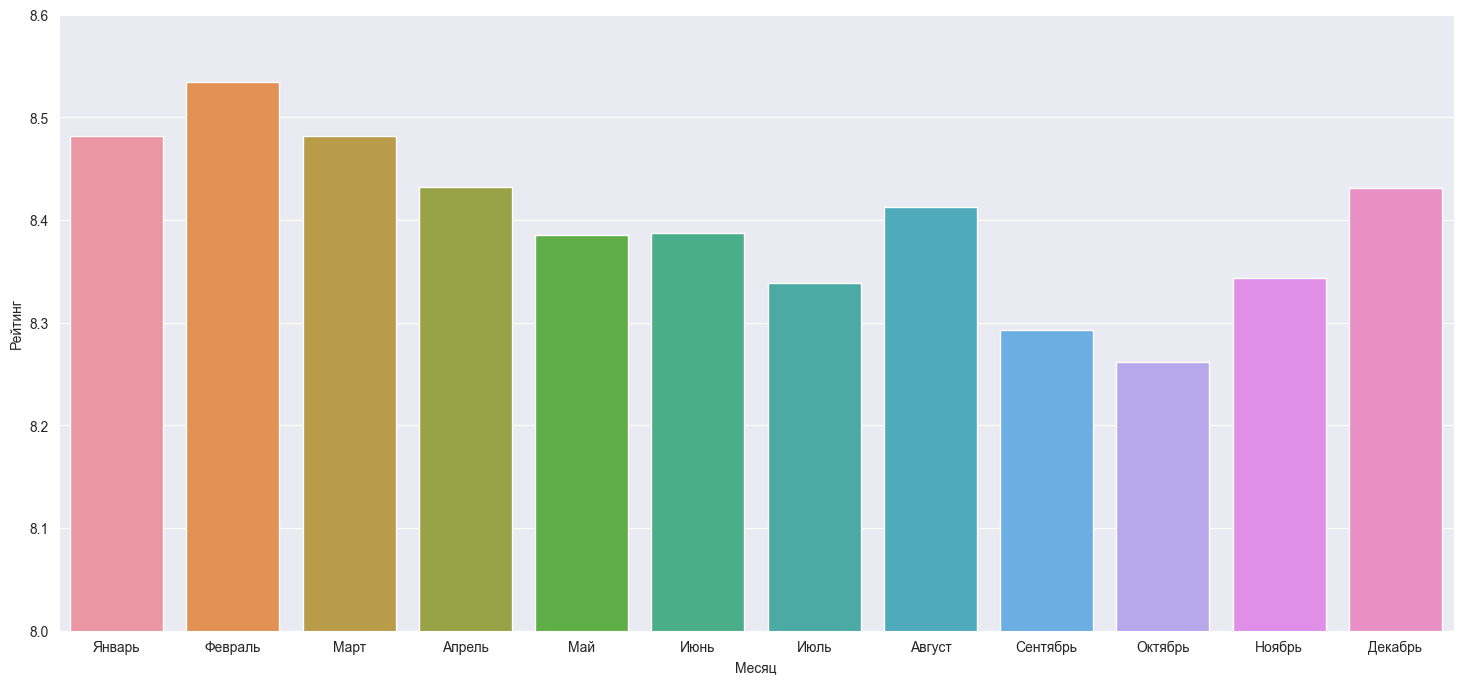

In [210]:
_temp_data = hotels[hotels['sample']==1].pivot_table(
    values='reviewer_score',
    index='review_month',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(18, 8))
bar_month = sns.barplot(
    x=_temp_data.index,
    y=_temp_data['reviewer_score'])
ax.set_xlabel('Месяц')
ax.set_ylabel('Рейтинг')
ax.set_xticklabels([
    'Январь', 'Февраль', 'Март',
    'Апрель', 'Май', 'Июнь',
    'Июль', 'Август', 'Сентябрь',
    'Октябрь', 'Ноябрь', 'Декабрь'])


plt.ylim(8, 8.6);

Заменим признак days_since_review на числовой.

In [211]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: np.float64(re.findall(r'\d+', x)[0])).convert_dtypes()

In [212]:
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_score,tags,days_since_review,sample,hotel_country,hotel_city,hotel_country_code,reviewer_nationality_code,count_nights,review_month
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2016-02-19,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531,1,United Kingdom,London,5,214,2,2
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,2017-01-12,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203,1,United Kingdom,London,5,214,1,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.900,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,...,7.500,"[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",289,1,France,Paris,1,43,3,10
3,216 Avenue Jean Jaures 19th arr 75019 Paris France,34,2015-09-22,7.500,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotlessly clean excellent location,...,10.000,"[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']",681,1,France,Paris,1,214,1,9
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.500,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakfasts were just extraordinary Room was clean quiet and very spacious,...,9.600,"[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']",516,1,Netherlands,Amsterdam,3,161,6,3


### 2.7 Количество слов в негативных и положительных отзывах

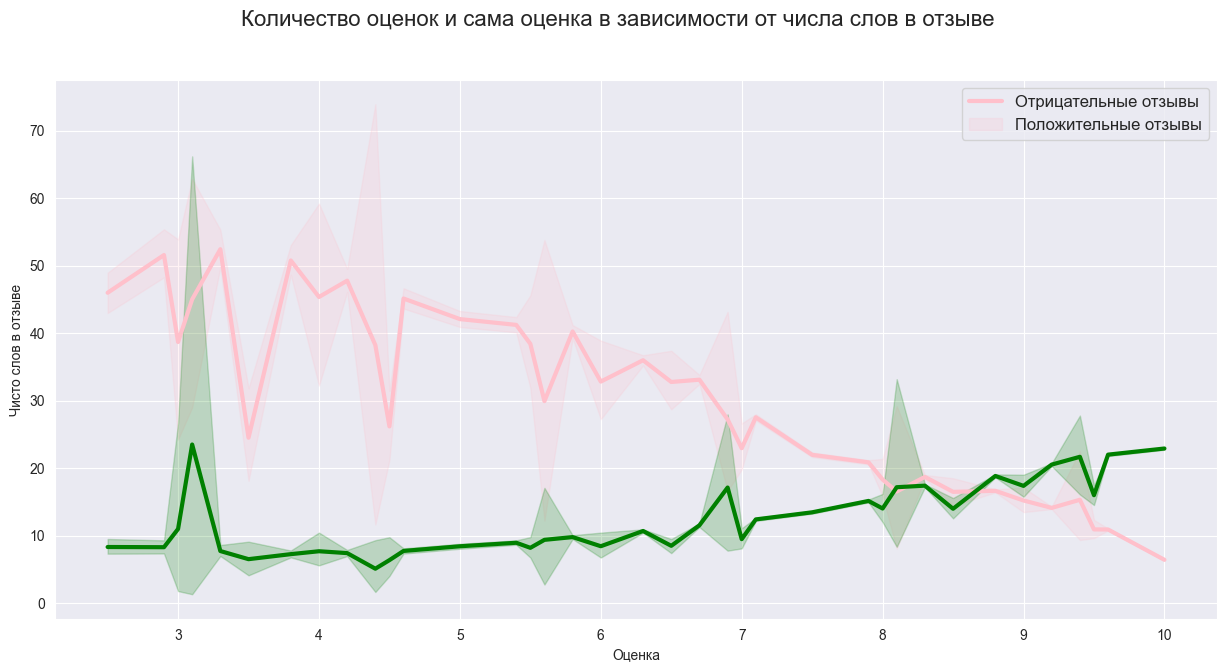

In [215]:
# Проверим наше предположение из предпоследнего markdown
fig, ax = plt.subplots(figsize=(18, 8))
plt.suptitle('Количество оценок и сама оценка в зависимости от числа слов в отзыве', size=16)
negative = sns.lineplot(
    data=hotels[hotels['sample']==1],
    x='reviewer_score',
    y='review_total_negative_word_counts',
    color='pink', linewidth=3
)
positive = sns.lineplot(
    data=hotels[hotels['sample']==1],
    x='reviewer_score',
    y='review_total_positive_word_counts',
    color='green', linewidth=3
)
ax.set_xlabel('Оценка')
ax.set_ylabel('Чисто слов в отзыве')
ax.legend(['Отрицательные отзывы', 'Положительные отзывы'], loc='upper right', fontsize=12);